#  Soft Rock Singers Tweets

### By Maria Gil Rodriguez

For this project my corpus will consist on tweets from singers.

To make classification a bit more difficult, I chose 9 singers similar to Jack Johnson and Jack himself. The profile of this 10 artists is: American singer-songwriter, male, born in the 70's or late 60's, multi-instrumentalist, and whose genre is considered soft rock and/or folk rock. Also, he must be active on twitter. 

The chosen artists are:
- Jack Johnson
- John Mayer
- Jason Mraz
- Matt Wertz
- Dave J. Matthews
- RayLaMontagne
- Donavon Frankenreiter
- Mat Kearney
- Ben Harper
- Chadwick Stokes

(Here is a link to Jack Johnson's Pandora station, where you can liste to many of the chosen artists while you read if you wish https://www.pandora.com/station/play/4065421129030866047)

In this project, I will scrape the tweets, clean the data and prepare it for modeling with Bag of Words and TF-IDF. Also, I will use unsupervised methods like Clustering, and Latent Semantic Analysis (LSA) to analyze the data, and will use classifiers to determine how alike the tweets are, and if the singers actually reporting similar information, and if the classifiers can accurately predict the source of the tweet.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette('hls', 10)
sns.set_palette(current_palette)
import os
import json
import re
from nltk import word_tokenize     
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, AffinityPropagation, estimate_bandwidth, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import tweepy
import warnings
warnings.filterwarnings('ignore')

## 1) Data Scraping:

To scrape the data we used **tweepy**, an open-sourced library, hosted on GitHub, that enables Python to communicate with Twitter platform and use its API (https://github.com/tweepy/tweepy).

In [2]:
# Keys and tokens
costumer_token = 'oXbJxomQj8DP49PX0hZgSVeB4' 
costumer_secret = 'vnkPVWV2VtyQzJICnvvggqAQ3HhCF6a5aKG3rnMgOyKvXVyFI5'
access_token = '1198615692-XHyGD0HUjIvZUJ7u3VJgXiHsT27sMQPp5kF4VJQ' 
access_token_secret = 'XKbuupS5HDM9VNt5jMl0LhBaC5Y6CZETiwuiC8U34ajqP'

In [3]:
# Entering credentials to utilize Tweepy
auth = tweepy.OAuthHandler(costumer_token, costumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [4]:
# Just Checking that it worked
user = api.me()
print (user.name)

María Gil Rodríguez


In [5]:
singers = ['jackjohnson', 'Johnmayer', 'jason_mraz', 'mattwertz', 'DaveJMatthews',
           'RayLaMontagne', 'dfrankenreiter', 'matkearney', 'BenHarper', 'chadwickstokes']

In [7]:
#Open a blank .json file for each singer, will append tweets later
for singer in singers:
    with open(f'{singer}.json', 'w') as f:
        try: 
            json.load(f)
        except ValueError:
            empty = [] 

In [8]:
#Twitter's API only allows for 200 records per call
TWEETS_PER_CALL = 200

def save_tweets(screen_nm, tweets):
    # 'a' appends to the .json we wrote with 'w' above
    with open(f'{screen_nm}.json', 'a') as f:
        for tweet in tweets:
            json.dump([tweet.full_text, screen_nm], f); f.write('\n')

def get_tweets(screen_nm, desired_ct):
    
    #desired_ct is the number of tweets the user wants to include
    tweet_list = []

    #grab the current maximum tweet id for provided screen name, which will be the id of the first tweet stored in the object
    curr_max_id = api.user_timeline(screen_name = screen_nm)[0].id 
    
    #may have to do more than 1 call to the API (if user wants > TWEETS_PER_CALL tweets)
    remaining = desired_ct
        
    while remaining > 0:
        tweets = api.user_timeline(screen_name = screen_nm, tweet_mode='extended', count = min(remaining, TWEETS_PER_CALL), max_id = curr_max_id, include_rts=False)
        
        #save these tweets in a json file for later, in case kernel crashes or want to reference at a later date
        save_tweets(screen_nm, tweets)
        
        for tweet in tweets:
            tweet_list.append([tweet.full_text, screen_nm])
                
        remaining = remaining - min(remaining, TWEETS_PER_CALL)
        
        #re-set the maximum id for every TWEETS_PER_CALL tweets, so that we don't include duplicate tweets
        curr_max_id = tweets[-1].id 
    return tweet_list

In [9]:
#Create tweet lists
singer_list_names = ['Jack_Johnson', 'John_Mayer', 'Jason_Mraz', 'Matt_Wertz', 
                     'Dave_Matthews', 'Ray_LaMontagne', 'Donavon_Frankenreiter', 
                     'Mat_Kearney', 'Ben_Harper', 'Chadwick_Stokes']

for singer_list, singer in zip(singer_list_names, singers): 
    singer_list = get_tweets(singer, 1000)    

In [10]:
full_tweets = []
for singer in singers:
    with open(f'{singer}.json'.format(singer)) as f: 
        full_tweets.append([json.loads(line) for line in f])
        

all_tweets = []
for auth in full_tweets:
    all_tweets.extend(auth[:500])
    
#Store in dataframe
df = pd.DataFrame(all_tweets, columns = ['Tweets', 'Singer'])
df.reindex(df.drop_duplicates(keep=False).index)
df.head()

,Tweets,Singer
0,Help support our friends at @NotesforNotes! ht...,jackjohnson
1,"Congrats to Kim Johnson, Jack's wife and manag...",jackjohnson
2,We are excited to announce that Jack &amp; the...,jackjohnson
3,Glastonbury bans single-use plastic bottles ht...,jackjohnson
4,“Never trust a musician who plays with their e...,jackjohnson


Let's make sure we have the same number of tweets for each singer.

In [11]:
df.groupby(['Singer']).count()

,Tweets
Singer,
BenHarper,500
DaveJMatthews,500
Johnmayer,500
RayLaMontagne,500
chadwickstokes,500
dfrankenreiter,500
jackjohnson,500
jason_mraz,500
matkearney,500


## 2) Data cleaning:

Now that we have the data in a dataframe, we need to clean it. We are going to remove all the non-alphanumeric characters, as well as the numeric ones. We'll also remove the URLs and the words with less than 3 characters. 

In [12]:
df['Tweets'] = df['Tweets'].str.replace('http\S+', '') # for URLs
df['Tweets'] = df['Tweets'].str.replace('\d+', '') # for digits
df['Tweets'] = df['Tweets'].str.replace(r'(\b\w{1,2}\b)', '') # for words less 3 characters
df['Tweets'] = df['Tweets'].str.replace('[^\w\s]', '') # for punctuation
df['Tweets'] = df['Tweets'].str.replace('_', '') # for _
df['Tweets'] = df['Tweets'].str.replace('amp', '') # for &

In [13]:
df.head()

,Tweets,Singer
0,Help support our friends NotesforNotes,jackjohnson
1,Congrats Kim Johnson Jack wife and manager wh...,jackjohnson
2,are excited announce that Jack the band wil...,jackjohnson
3,Glastonbury bans singleuse plastic bottles vi...,jackjohnson
4,Never trust musician who plays with their eye...,jackjohnson


In [14]:
print(df.Tweets[1])

Congrats  Kim Johnson Jack wife and manager who will  honored with  Women Making Waves award  the Surfrider One Ocean event  October PlasticFreeWave AAOPlasticFree PlasticFreeHawaii 


It looks goods, we have capitals, but the vectorizer in the next section will take care of it. 

## 3) Pre-processing:

### *BoW*

The next step will be building a common **bag of words** for all the artists. For that, we will use the nltk CountVectorizer configured to be able to tokenize, lemmatize, convert into lowercase and remove the stop words. We will also remove the words that are used less than 3 times. 

In [15]:
Y = df.Singer
X = df.Tweets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)

(3750,)
(1250,)


In [16]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, tweets):
        return [self.wnl.lemmatize(t) for t in word_tokenize(tweets)]

In [17]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", analyzer='word', vocabulary =None, 
                             ngram_range=(1, 1), max_df=1.0, min_df=3, max_features=None)
bow = vectorizer.fit_transform(X_train)

features_names = vectorizer.get_feature_names()
print(len(features_names))
print(bow.shape)
X_train_bow = pd.DataFrame(bow.todense(), columns=features_names)
X_train_bow.head(5)

1815
(3750, 1815)


,aaolocalfood,aaoplasticfree,abc,able,absolutely,access,acoustic,act,action,actonclimate,...,yes,yesterday,york,young,youtubespaceny,zachgillalo,zealand,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our bag of words looks pretty good. We just need to create the same transformation in the hold out group before moving on.

In [18]:
# Perform the same transformation in the hold out group.
test_bow = vectorizer.transform(X_test)
X_test_bow = pd.DataFrame(test_bow.todense(), columns=features_names)
X_test_bow.shape

(1250, 1815)

### *tf-idf*

We will continue by applying **term frequency–inverse document frequency** in order to reflect how important a word is to a document in our corpus.

In [19]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)
tfidf.shape

(3750, 1815)

In [20]:
X_train_tf = pd.DataFrame(tfidf.todense(), columns=features_names)
X_train_tf.head()

,aaolocalfood,aaoplasticfree,abc,able,absolutely,access,acoustic,act,action,actonclimate,...,yes,yesterday,york,young,youtubespaceny,zachgillalo,zealand,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Perform the same transformation in the hold out group.
test_tf = tfidf_transformer.transform(test_bow)
X_test_tf = pd.DataFrame(test_tf.todense(), columns=features_names)
X_test_tf.shape

(1250, 1815)

### *LSA*

Both our BoW and our tf-idf dataframes have 1826 features. We will now reduce dimensionality using **Latent semantic analysis**. After this porcess we will only keep the 500 best features.

In [22]:
#Our SVD data reducer. Features are reduced down to 500.
svd = TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.

LSA = lsa.fit_transform(X_train_tf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('The percentage of total variance in the dataset explained by each component from LSA:\n',
      variance_explained[:10], '...')
print("Percent variance captured by all components:",total_variance*100)

The percentage of total variance in the dataset explained by each component from LSA:
 [0.00582838 0.00910676 0.00849108 0.00746443 0.00729943 0.00713692
 0.00682082 0.00650896 0.00619901 0.00588104] ...
Percent variance captured by all components: 71.09966698377214


It seems that with only 500 features we are able to explain over 70% of the variance. Let's represent some of the components against others to see how it looks.

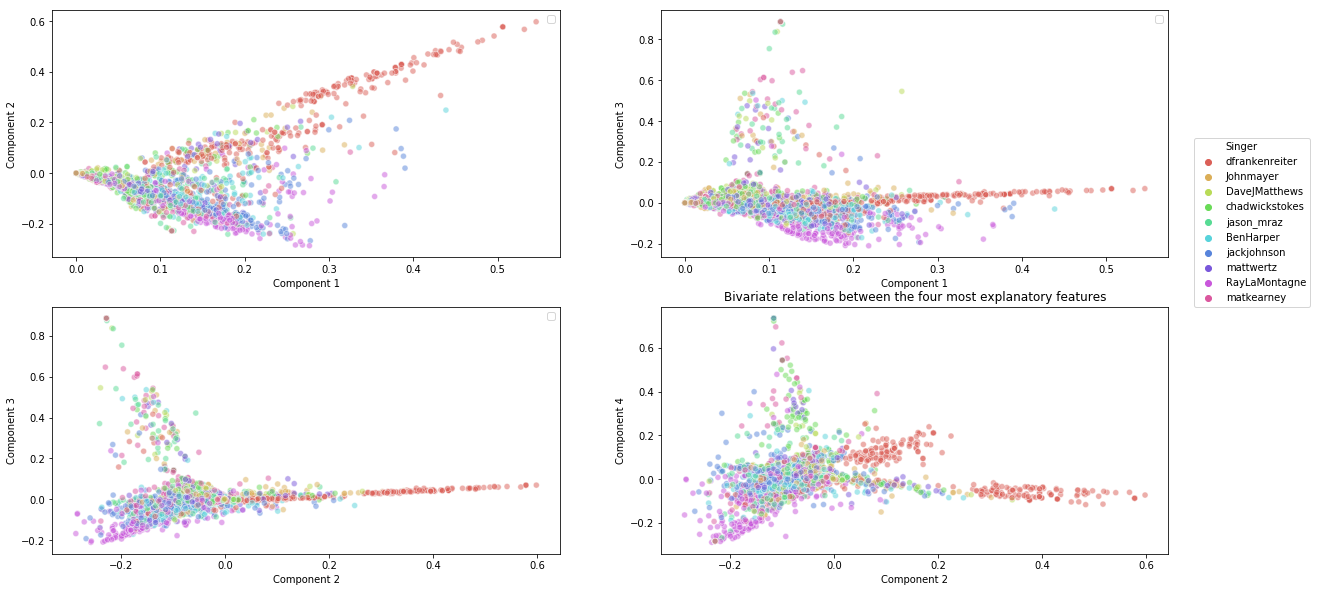

In [23]:
# Plot bivariate relations
plt.figure(figsize=(20,10))
for i, c in enumerate([(0,1), (0,2), (1,2), (1,3)]): 
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=LSA[:, c[0]], y=LSA[:, c[1]], hue=Y_train, alpha=.5)
    plt.legend('')
    plt.xlabel('Component ' + str(c[0]+1))
    plt.ylabel('Component ' + str(c[1]+1))
plt.legend(loc = (1.05, 1))
plt.title('Bivariate relations between the four most explanatory features')
plt.show()

We can see how some singers are clearly different, like 'dfrankenreiter' and 'RayLaMontagne'. They should be able to stand out in later on in our models.

We can now compute the similarity. Let's visualized the first 25 components.

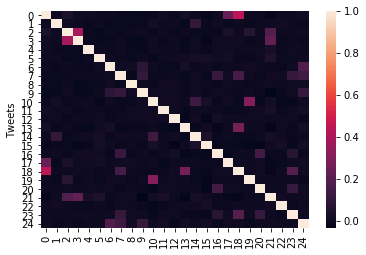

Key:
0 Just Announced Cincinnati   Oct   LIVE   
1 You have  high speed collision with  Most good mature people  have had their humility delivered  them via  boot  one way  another 
2 Okay  does look like   Hahahaha  have  give you that  looks like    looks like    just want the great stuff  win  looks like  
3 RayshanDMB nice  like that  also like your pill box Hey rayshan
4 PAC northwest here come the lobbyists  
5  love when this happens 
6   delighted  reunite with the Berlinbased hoertberge whose beautiful music and positive messages are exactly what the world needs always  few tickets are still available for select  dates here 
Join   harmony 
7 Tune into tavissmiley tonight  PBS  watch Ben play title track  bhic callitwhatitis Check local listings 
8  ActOnClimate because this   favorite planet kokua  aaoplasticfree plasticfreehawaii photo PeteHodgson 
9   play solo shows  LokerseFeesten CapRoigFestival and StarliteFest this August  Tickets  sale now except Starlite March  
10  

In [24]:
# Compute document similarity using LSA component
similarity = cosine_similarity(LSA)
# Only the first 25 components
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:25,0:25]

ax = sns.heatmap(sim_matrix,yticklabels=range(25))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(25):
    print(i,sim_matrix.index[i])

Not bad! In general, we do not see much similarity. Only 0 and 18, talking about an event in October, and 2 and 3, which use 'like' many times, are moderately correlated. Note that it also cought the slight similarity between 10 and 19: talking about health issues. Pretty cool!

Again, we cannot forget about of test set.

In [25]:
# Perform the same transformation in the hold out group.
X_train_LSA = LSA
LSA_test = lsa.transform(X_test_tf)
X_test_LSA = LSA_test

## 4) Supervised learning models:

We are going to run 3 different models:
* Random Forest Classifier,
* Logistic Regression, and
* Support Vector Machine.

For comparative purposes, we will use the BoW, tfidf and LSA dataframes, but we will only tune the last one.

Let's do some modeling!

### *Model 1: Random Forest*

##### RF with BoW

In [26]:
rfc = RandomForestClassifier(n_estimators=10, random_state=0)
rfc.fit(X_train_bow, Y_train)

rfc_train_bow = rfc.score(X_train_bow, Y_train)
rfc_cross_bow = cross_val_score(rfc, X_train_bow, Y_train, cv=5)
print('Training set score:\t\t', rfc_train_bow)
print('Cross validation scores:\t', rfc_cross_bow)

Training set score:		 0.9362666666666667
Cross validation scores:	 [0.57824934 0.57978723 0.59066667 0.57887701 0.53619303]


##### RF with tf_idf:

In [27]:
rfc.fit(X_train_tf, Y_train)

rfc_train_tf = rfc.score(X_train_tf, Y_train)
rfc_cross_tf = cross_val_score(rfc, X_train_tf, Y_train, cv=5)
print('Training set score:\t\t', rfc_train_tf)
print('Cross validation scores:\t', rfc_cross_tf)

Training set score:		 0.936
Cross validation scores:	 [0.58355438 0.60239362 0.59066667 0.59893048 0.57908847]


##### RF with LSA:

In [28]:
rfc.fit(X_train_LSA, Y_train)

rfc_train_LSA = rfc.score(X_train_LSA, Y_train) 
rfc_cross_LSA = cross_val_score(rfc, X_train_LSA, Y_train, cv=5)
print('Training set score:\t\t', rfc_train_LSA)
print('Cross validation scores:\t', rfc_cross_LSA)

Training set score:		 0.9418666666666666
Cross validation scores:	 [0.42440318 0.4481383  0.44666667 0.44385027 0.45040214]


##### RF tuning:

In [29]:
params_CV = {'n_estimators': [1000, 200],
             'max_depth': [50, 100, 150],
             'criterion': ['entropy', 'gini']}

# Initialize and fit the model.
rfc = RandomForestClassifier()
optimized_rfc = GridSearchCV(rfc, params_CV, cv = 5, n_jobs = -1) 
optimized_rfc.fit(X_train_LSA, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000, 200], 'max_depth': [50, 100, 150], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
optimized_rfc.best_params_

{'criterion': 'gini', 'max_depth': 150, 'n_estimators': 1000}

In [31]:
optimized_rfc_train_LSA = optimized_rfc.score(X_train_LSA, Y_train)
optimized_rfc_cross_LSA = optimized_rfc.best_score_
print('Training set score:\t\t', rfc_train_LSA)
print('Best cross validation score:\t', optimized_rfc_cross_LSA)

Training set score:		 0.9418666666666666
Best cross validation score:	 0.6002666666666666


### *Model 2: Logistic Regression*

##### LR with BoW 

In [32]:
lr = LogisticRegression(solver='lbfgs', random_state=0)
lr.fit(X_train_bow, Y_train)

lr_train_bow = lr.score(X_train_bow, Y_train)
lr_cross_bow = cross_val_score(lr, X_train_bow, Y_train, cv=5)
print('Training set score:\t\t', lr_train_bow)
print('Cross validation scores:\t', lr_cross_bow)

Training set score:		 0.8733333333333333
Cross validation scores:	 [0.64323607 0.62367021 0.63866667 0.65775401 0.65549598]


##### LR with tf-idf:

In [33]:
lr.fit(X_train_tf, Y_train)

lr_train_tf = lr.score(X_train_tf, Y_train)
lr_cross_tf = cross_val_score(lr, X_train_tf, Y_train, cv=5)
print('Training set score:\t\t', lr_train_tf)
print('Cross validation scores:\t', lr_cross_tf)

Training set score:		 0.8336
Cross validation scores:	 [0.64721485 0.64361702 0.63733333 0.6657754  0.64879357]


##### LR with LSA:

In [34]:
lr.fit(X_train_LSA, Y_train)

lr_train_LSA = lr.score(X_train_LSA, Y_train)
lr_cross_LSA = cross_val_score(lr, X_train_LSA, Y_train, cv=5)
print('Training set score:\t\t', lr_train_LSA)
print('Cross validation scores:\t', lr_cross_LSA)

Training set score:		 0.768
Cross validation scores:	 [0.63129973 0.63297872 0.63866667 0.64973262 0.64477212]


##### LR tuning:

In [35]:
params_CV = {'C': [1, 2, 3],
             'penalty': ['l1', 'l2']}
# Initialize and fit the model.
lr = LogisticRegression(max_iter=1000, random_state=0)
optimized_lr = GridSearchCV(lr, params_CV, cv = 5, n_jobs = -1) 
optimized_lr.fit(X_train_LSA, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 2, 3], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
optimized_lr.best_params_

{'C': 3, 'penalty': 'l2'}

In [37]:
optimized_lr_train_LSA = optimized_lr.score(X_train_LSA, Y_train)
optimized_lr_cross_LSA = optimized_lr.best_score_
print('Training set score:\t\t', optimized_lr_train_LSA)
print('Best Cross validation score:\t', optimized_lr_cross_LSA)

Training set score:		 0.7962666666666667
Best Cross validation score:	 0.6445333333333333


### *Model 3: Support Vector Machine*

##### SVC with BoW:

In [38]:
svm = SVC(kernel = 'linear', random_state=0)
svm.fit(X_train_bow, Y_train)

svm_train_bow = svm.score(X_train_bow, Y_train)
svm_cross_bow = cross_val_score(svm, X_train_bow, Y_train, cv=5)
print('Training set score:\t\t', svm_train_bow)
print('Cross validation scores:\t', svm_cross_bow)

Training set score:		 0.9050666666666667
Cross validation scores:	 [0.57427056 0.5731383  0.58       0.61363636 0.59517426]


##### SVC with tf-idf:

In [39]:
svm.fit(X_train_tf, Y_train)

svm_train_tf = svm.score(X_train_tf, Y_train)
svm_cross_tf = cross_val_score(svm, X_train_LSA, Y_train, cv=5)
print('Training set score:\t\t', svm_train_tf)
print('Cross validation scores:\t', svm_cross_tf)

Training set score:		 0.8589333333333333
Cross validation scores:	 [0.6193634  0.63164894 0.61866667 0.63636364 0.63538874]


##### SVC with LSA:

In [40]:
svm.fit(X_train_LSA, Y_train)

svm_train_LSA = svm.score(X_train_LSA, Y_train)
svm_cross_LSA = cross_val_score(svm, X_train_LSA, Y_train, cv=5)
print('Training set score:\t\t', svm_train_LSA)
print('Cross validation scores:\t', svm_cross_LSA)

Training set score:		 0.7856
Cross validation scores:	 [0.6193634  0.63164894 0.61866667 0.63636364 0.63538874]


##### SVC tuning:

In [41]:
params_CV = {'kernel': ['linear', 'poly', 'rbf'],
             'C': [.1, 1, 10],
             'gamma' : [.1, 1, 10]}
# Initialize and fit the model.
svm = SVC(random_state=0)
optimized_svm = GridSearchCV(svm, params_CV, cv = 5, n_jobs = -1) 
optimized_svm.fit(X_train_LSA, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
optimized_svm.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [43]:
optimized_svm_train_LSA = optimized_svm.score(X_train_LSA, Y_train)
optimized_svm_cross_LSA = optimized_svm.best_score_
print('Training set score:\t\t', optimized_svm_train_LSA)
print('Best Cross validation score:\t', optimized_svm_cross_LSA)

Training set score:		 0.8928
Best Cross validation score:	 0.6392


### *Summary*

In [44]:
summary = np.array([['Random Forest Classifier','%0.3f' % np.mean(rfc_cross_bow),
                     '%0.3f' % np.mean(rfc_cross_tf),
                     '%0.3f' % np.mean(rfc_cross_LSA),
                     '%0.3f' % optimized_rfc_cross_LSA],
                  ['Logistic Regression','%0.3f' % np.mean(lr_cross_bow),
                      '%0.3f' % np.mean(lr_cross_tf),
                      '%0.3f' % np.mean(lr_cross_LSA),
                      '%0.3f' % optimized_lr_cross_LSA],
                  #['Gradient Boosting Regression','%0.3f' % clf_test_bow,
                  #    "%0.3f" % clf_test_tf],
                  ['Support Vector Machine','%0.3f' % np.mean(svm_cross_bow),
                      '%0.3f' % np.mean(svm_cross_tf),
                      '%0.3f' % np.mean(svm_cross_LSA),
                      '%0.3f' % optimized_svm_cross_LSA]])

df_summary = pd.DataFrame(summary)
df_summary.columns = ['Model','Untuned BoW','Untuned df-idf', 'Untuned LSA', 'Tuned LSA']

df_summary.head()

,Model,Untuned BoW,Untuned df-idf,Untuned LSA,Tuned LSA
0,Random Forest Classifier,0.573,0.591,0.443,0.600
1,Logistic Regression,0.644,0.649,0.639,0.645
2,Support Vector Machine,0.587,0.628,0.628,0.639


Considering how short tweets and how similar the artists are, the predictions are actually not bad at all.

Overall, the best model was Logistic Regression, closely followed by SVM, although the running time for the latter was significantly longer. All the models had some degree of overfitting, but random forest was the one that overfit the most.

Among the logistic regression models, we were able to make up the loss of information due to LSA by tunning the model. Because it overfit the least (0.79/0.64) and the score is still pretty good, we choose the LSA logistic regression after tuning as the best model and will use it with the hold up group.

Let's take a look of the confusion matrix:

In [45]:
print("Report:")
y_pred = optimized_lr.predict(X_train_LSA)
print(classification_report(Y_train, y_pred))
confusion_matrix(Y_train, y_pred)

Report:
                precision    recall  f1-score   support

     BenHarper       0.93      0.84      0.88       372
 DaveJMatthews       0.56      0.78      0.65       392
     Johnmayer       0.64      0.65      0.65       379
 RayLaMontagne       0.95      0.94      0.94       371
chadwickstokes       0.77      0.76      0.76       378
dfrankenreiter       0.98      0.99      0.98       389
   jackjohnson       0.95      0.92      0.94       376
    jason_mraz       0.81      0.76      0.78       373
    matkearney       0.70      0.62      0.66       370
     mattwertz       0.78      0.69      0.73       350

     micro avg       0.80      0.80      0.80      3750
     macro avg       0.81      0.79      0.80      3750
  weighted avg       0.81      0.80      0.80      3750



array([[312,  22,   7,   4,   2,   2,   5,  10,   5,   3],
       [  0, 307,  32,   2,  16,   2,   0,  10,  16,   7],
       [  4,  60, 247,   3,  16,   1,   1,  12,  25,  10],
       [  3,   0,   4, 347,   2,   1,   0,   5,   4,   5],
       [  4,  31,  18,   3, 287,   1,   6,   5,  11,  12],
       [  0,   2,   0,   0,   0, 385,   1,   0,   0,   1],
       [  4,   6,   1,   1,   5,   0, 346,   6,   5,   2],
       [  5,  28,  18,   2,  12,   1,   2, 283,  12,  10],
       [  0,  61,  31,   2,  17,   0,   1,  10, 231,  17],
       [  2,  32,  28,   1,  16,   0,   1,   8,  21, 241]], dtype=int64)

In the train set, we were able to differentiate very well from the rest the tweets from dfrankenreiter, jackjohnson and RayLaMontagne. 

## 5) Clustering

After using our supervised models, let's see how well unsupervised learning works with our LSA dataframe. We are going to perform some clustering using K-means and agglomerative clustering for different number of clusters.

To be able to evaluate our clusters, we will divide the training set into 4 groups.

### *K-means*

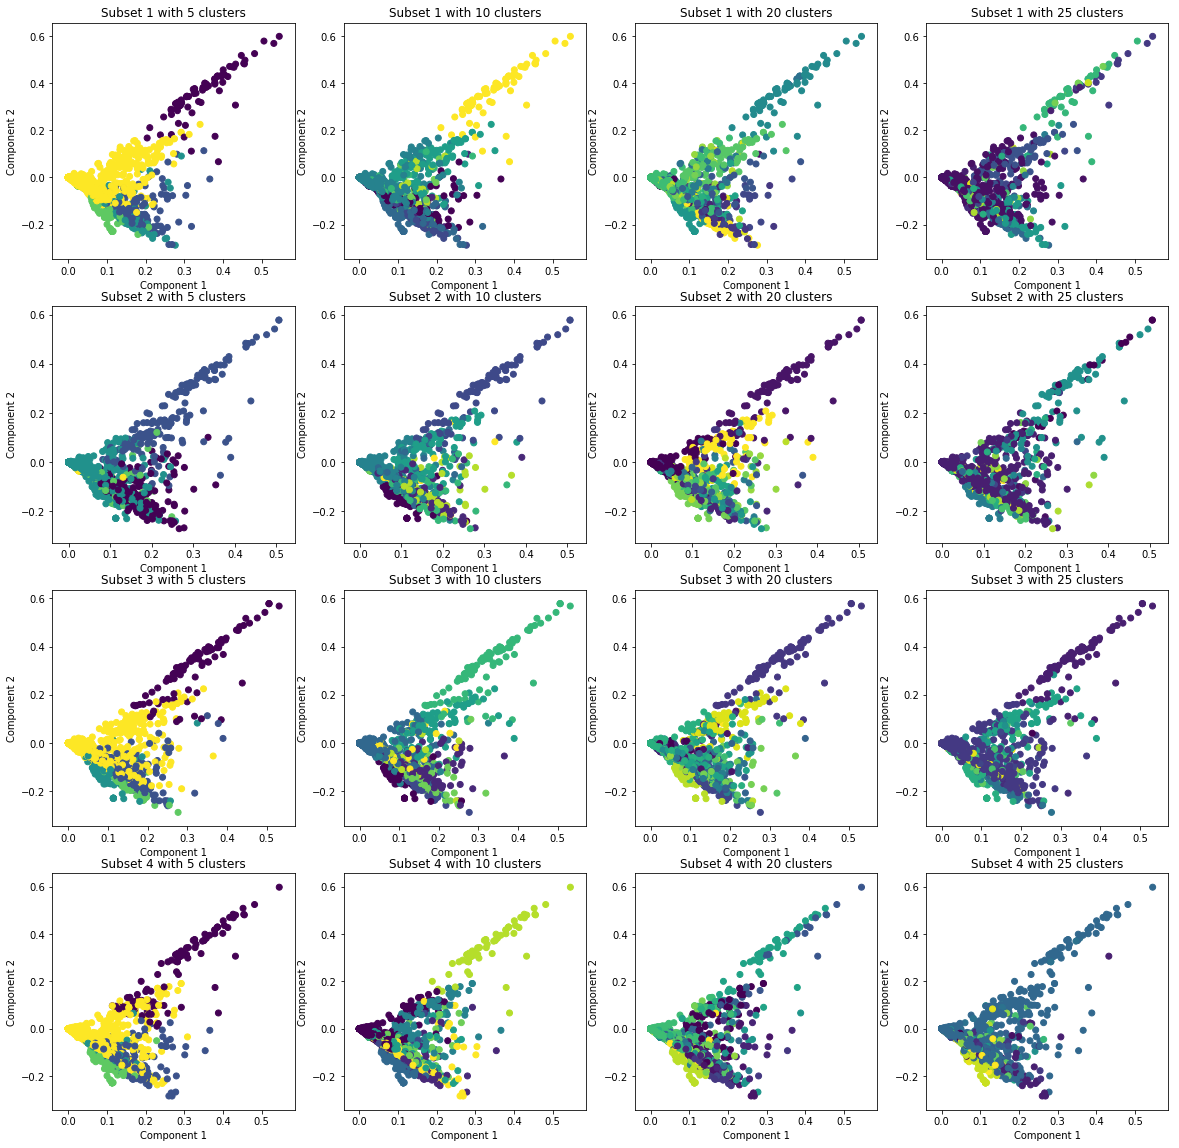

In [46]:
# Split the data to test for consistent clustering
lsa1, lsa3= train_test_split(X_train_LSA, test_size=0.50)
lsa1, lsa2= train_test_split(X_train_LSA, test_size=0.50)
lsa3, lsa4= train_test_split(X_train_LSA, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (5, 10, 20, 25)

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [47]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', round(metrics.adjusted_rand_score(Y_train, pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return 

In [48]:
cluster_eval(clusters, preds, models, 20)

print(f'\nResults for 20 clusters:') 
pd.crosstab(Y_train, preds[4,20]).T

Adjusted Rand index for 5 clusters: 0.03451
The silhouette coefficient for 5 clusters: 0.0241 

Adjusted Rand index for 10 clusters: 0.04917
The silhouette coefficient for 10 clusters: 0.0344 

Adjusted Rand index for 20 clusters: 0.06666
The silhouette coefficient for 20 clusters: 0.0525 

Adjusted Rand index for 25 clusters: 0.02385
The silhouette coefficient for 25 clusters: 0.0443 


Results for 20 clusters:


Singer,BenHarper,DaveJMatthews,Johnmayer,RayLaMontagne,chadwickstokes,dfrankenreiter,jackjohnson,jason_mraz,matkearney,mattwertz
col_0,,,,,,,,,,
0,6,19,37,8,30,0,7,18,18,26
1,3,3,5,2,6,123,4,0,0,5
2,4,10,8,3,5,2,2,19,26,9
3,1,0,1,87,0,0,0,1,0,0
4,1,9,2,6,40,0,3,4,19,14
5,7,2,2,2,13,129,6,6,2,10
6,72,0,0,0,3,0,0,0,0,0
7,65,0,0,0,0,0,0,0,0,0
8,4,15,10,1,14,0,4,36,6,15


K-means didn't do a good job. For all the cases tested (we actually tested all cases from 2 to 30, but we only include these 4 cases for simplification), it clustered most of the tweets in one big group.

It looks like 20 clusters is the least bad. As we predicted from the LSA plots, dfrankenreiter was easy to separate. It was also able to separate a good amount of RayLaMontagne, jackjohnson and BenHarper tweets.

Let's now see what are the most common words for each cluster:

In [49]:
#Define a function to extract common words and occurrences
def find_common_words(i):
    common_words=[]
    idx = X_train_bow[preds[4,20]==i].index
    order = sorted(X_train_bow.iloc[idx].sum(), reverse=True)[0:10]
    for o in order:
        common_word = list(X_train_bow.iloc[idx].sum()[X_train_bow.iloc[idx].sum()==o].index)
        common_words = common_words + common_word  
    for a, b in zip(pd.unique(common_words)[:5], order):
        print('  ', a, '  \t', b)

In [50]:
for i in range(20):
    print(f'\nCluster {i}:')
    find_common_words(i)


Cluster 0:
   come   	 56
   people   	 40
   great   	 39
   think   	 34
   right   	 20

Cluster 1:
   just   	 153
   announced   	 129
   aug   	 31
   mar   	 29
   beach   	 18

Cluster 2:
   love   	 108
   song   	 7
   guy   	 6
   hope   	 5
   friend   	 4

Cluster 3:
   poster   	 98
   tonight   	 81
   merch   	 40
   ray   	 35
   table   	 27

Cluster 4:
   thanks   	 99
   wa   	 9
   night   	 7
   having   	 6
   man   	 6

Cluster 5:
   today   	 184
   aug   	 47
   mar   	 26
   beach   	 15
   jun   	 15

Cluster 6:
   ben   	 73
   harper   	 54
   criminal   	 30
   innocent   	 30
   charlie   	 22

Cluster 7:
   bhic   	 65
   callitwhatitis   	 29
   sale   	 10
   shine   	 10
   tix   	 9

Cluster 8:
   good   	 121
   vibe   	 27
   ticket   	 12
   visit   	 10
   info   	 9

Cluster 9:
   yes   	 42
   andrewbelle   	 1
   askray   	 1
   away   	 1
   awesome   	 1

Cluster 10:
   day   	 63
   time   	 61
   tonight   	 51
   friend   	 43
   video 

Seing this, we understand a little better what happened. Some clusters are grouping very specific topics: cluster 9 grouped all the tweets that say yes, 4 the ones that thank, 2 the tweets about love, etc etc.

The big cluster, number 10, grouped the tweets that talk about time, which is a pretty common topic for singers (and everybody, really), that is why those were so difficult to separate.

K-means did a good job separating jackjohnson and dfrankenreiter, because they are mentioned in many of their tweets, and also separating the tweets about BenHarper's new album 'Innocent Criminals'.

### *Agglomerative clustering*

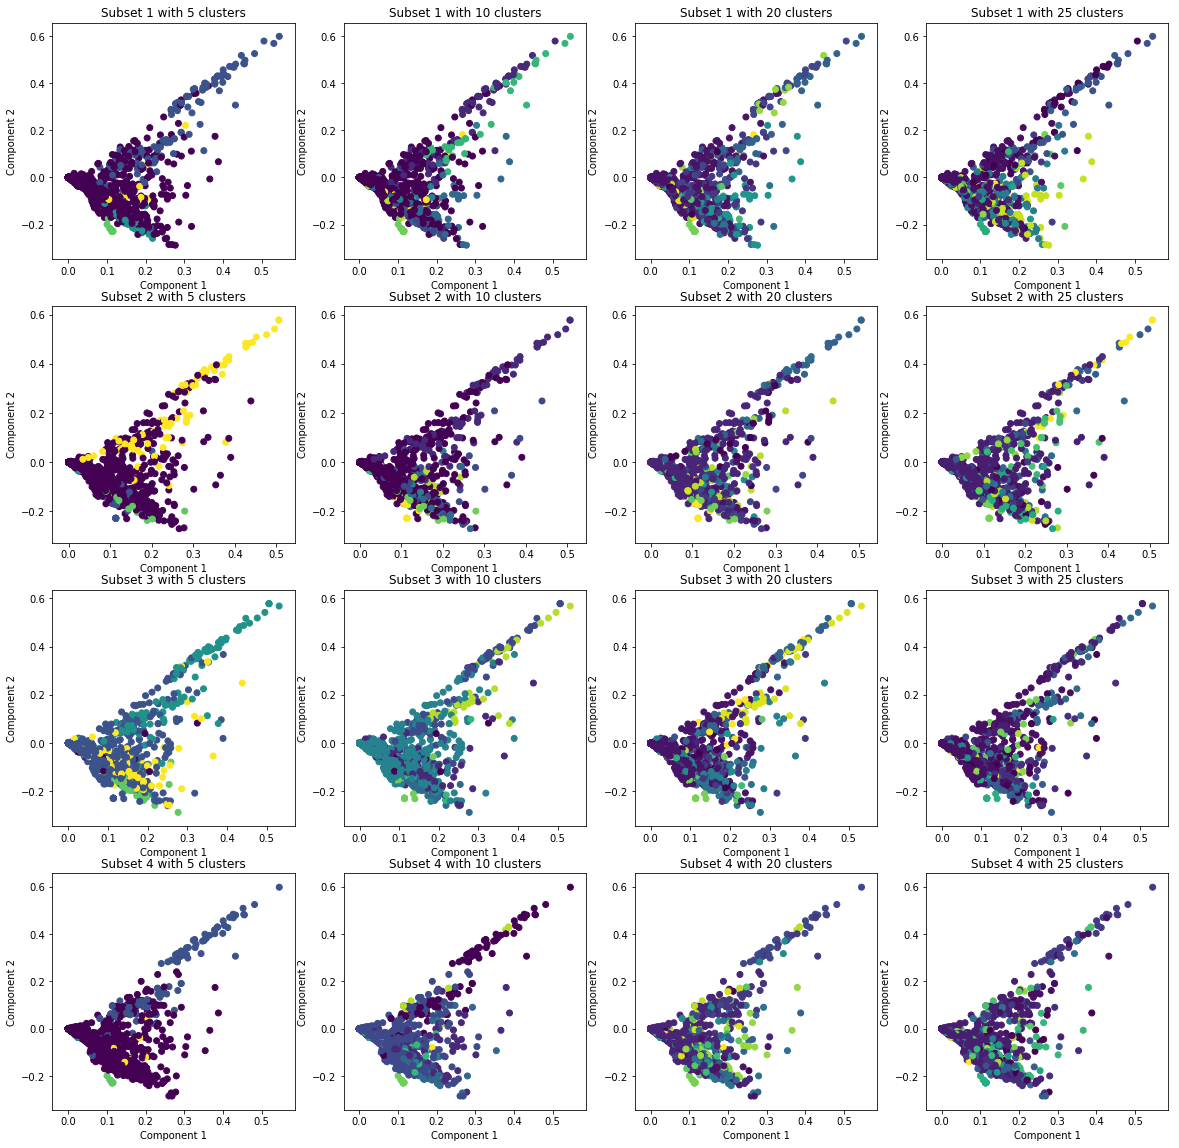

In [51]:
plt.figure(figsize=(20,20))

# Calculate predicted values.
preds_2 = {}
models_2 = {}

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them
    for col, nclust in  enumerate(clusters):
        models_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit(data)
        preds_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds_2[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [52]:
cluster_eval(clusters, preds_2, models_2, 20)

Adjusted Rand index for 5 clusters: 0.01601
The silhouette coefficient for 5 clusters: 0.0215 

Adjusted Rand index for 10 clusters: 0.02128
The silhouette coefficient for 10 clusters: 0.0189 

Adjusted Rand index for 20 clusters: 0.06166
The silhouette coefficient for 20 clusters: 0.0216 

Adjusted Rand index for 25 clusters: 0.06015
The silhouette coefficient for 25 clusters: 0.0222 



Agglomerative clustering worked even worse than K-means.

## 6) Testing our models:

We are now ready to run the best models on our test set.

### *Logistic regression with LSA* 

In [53]:
print(optimized_lr.score(X_test_LSA, Y_test))
print('Report:'')
y_pred = optimized_lr.predict(X_test_LSA)
print(classification_report(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

0.6304
Report:
                precision    recall  f1-score   support

     BenHarper       0.78      0.71      0.74       128
 DaveJMatthews       0.36      0.61      0.46       108
     Johnmayer       0.39      0.36      0.38       121
 RayLaMontagne       0.86      0.88      0.87       129
chadwickstokes       0.60      0.61      0.60       122
dfrankenreiter       0.88      0.95      0.91       111
   jackjohnson       0.93      0.81      0.86       124
    jason_mraz       0.53      0.54      0.54       127
    matkearney       0.52      0.39      0.45       130
     mattwertz       0.58      0.49      0.53       150

     micro avg       0.63      0.63      0.63      1250
     macro avg       0.64      0.64      0.63      1250
  weighted avg       0.64      0.63      0.63      1250



array([[ 91,   8,   2,   5,   3,   4,   1,  11,   0,   3],
       [  1,  66,  13,   4,   9,   0,   0,   6,   5,   4],
       [  7,  29,  44,   0,   7,   2,   0,  12,   9,  11],
       [  3,   0,   2, 114,   1,   0,   2,   5,   1,   1],
       [  1,  12,  10,   2,  75,   1,   2,   4,   9,   6],
       [  0,   1,   0,   1,   0, 105,   1,   1,   1,   1],
       [  3,   4,   3,   0,   3,   4, 100,   2,   2,   3],
       [  5,   8,  12,   3,   8,   2,   2,  69,   6,  12],
       [  1,  33,  13,   2,  12,   0,   0,   7,  51,  11],
       [  5,  21,  13,   1,   8,   1,   0,  13,  15,  73]], dtype=int64)

The model did a very good job predicting 3 of the singers. However, some of them had low precision and recall scores implying that their tweets were similar to other's. 

### *K Means with 20 clusters* 

In [54]:
pred =KMeans(n_clusters=20, random_state=42).fit_predict(X_test_LSA)

In [55]:
print('Adjusted Rand index for 20 clusters:\t\t', round(metrics.adjusted_rand_score(Y_test, pred),5))
print('The silhouette coefficient for 20 clusters: \t', round(metrics.silhouette_score(X_test_LSA, pred, metric='euclidean'),5))

Adjusted Rand index for 20 clusters:		 0.05385
The silhouette coefficient for 20 clusters: 	 0.05446


In [56]:
print(f'\nResults for 20 clusters:') 
pd.crosstab(Y_test, pred).T


Results for 20 clusters:


Singer,BenHarper,DaveJMatthews,Johnmayer,RayLaMontagne,chadwickstokes,dfrankenreiter,jackjohnson,jason_mraz,matkearney,mattwertz
col_0,,,,,,,,,,
0,17,2,4,18,0,7,11,9,0,0
1,3,1,1,5,0,0,43,4,0,2
2,41,69,65,22,57,13,24,45,77,74
3,0,0,0,20,0,0,0,0,0,0
4,5,1,1,1,3,28,1,0,0,4
5,1,1,5,0,0,1,1,9,5,6
6,1,16,17,0,6,0,0,5,4,5
7,5,0,1,6,5,0,3,3,4,11
8,0,7,3,0,7,0,1,12,2,2


As expected, the results are really bad. For the test set, it dint't even separate very well the 'easy' to predict singers.

## 7) Conclusions:

For this corpus, clustering is not a good fit. Supervised ML models worked much better, especially logistic regression. With this model, we were able to predict over 63% of the tweets correctly that, considering how many singers we had and how similar the topics they tweet about are, it is pretty good.

### Some prossible improvements
* Choosing different stop words
* Selecting a different threshold for infrequent words. Here, we excluded words that occurred less than 3 times, but they might be very few or too many
* Many artists tweet emojis. Studying them could be worth it.